In [7]:
from river.datasets import synth
from river import tree, stream, metrics, drift,forest
from itertools import chain
from itertools import cycle
import itertools
import random
from helper_lib import group_close_numbers, transform_drift_detections_into_intervals
from helper_lib import take_tests_for_streams_on_tree, prefix_sum, take_tests_for_streams_on_given_model
from helper_lib import take_tests_for_streams_on_given_model_experimental, visualize_interval_differences, visualize_results
from helper_lib import calculate_drift_intervals
from model_factory import TreeModelFactory, ARFModelFactory
from complex_generators import generate_cyclical_drift_stream, generate_random_chain_stream

In [8]:
def detector_factory_50_002():
    return drift.ADWIN(grace_period=50, delta=0.002)
def detector_factory_20_002():
    return drift.ADWIN(grace_period=20, delta=0.002)
def detector_factory_10_002():
    return drift.ADWIN(grace_period=10, delta=0.002)
def detector_factory_10_04():
    return drift.ADWIN(grace_period=10, delta=0.04)

In [10]:
from tqdm.notebook import tqdm
import pickle

# Define detector factories
generator_pool_sizes = [2, 3]
number_of_streams_list = [4, 6, 9]
number_of_features_list = [3, 5]
number_of_detectors_list = [20, 50]
max_gaps = [10]
min_group_sizes = [4]
detector_factorys = [
    detector_factory_50_002,
    detector_factory_20_002,
    detector_factory_10_002,
    detector_factory_10_04
]

results = {}

# Iterate over all parameter combinations with detector factories
param_grid = list(itertools.product(
    generator_pool_sizes,
    number_of_streams_list,
    number_of_features_list,
    number_of_detectors_list,
    max_gaps,
    min_group_sizes,
    detector_factorys
))

for (generator_pool_size, number_of_streams, number_of_features, number_of_detectors, max_gap, min_group_size, detector_factory) in tqdm(param_grid, desc="Grid Search"):
    samples_per_generator_list = [20000 for x in range(number_of_streams)]
    all_samples_number = sum(samples_per_generator_list)
    chained_generator, drift_widths = generate_cyclical_drift_stream(
        generator_pool_size=generator_pool_size,
        number_of_generators=number_of_streams,
        number_of_features=number_of_features,
        samples_per_generator=samples_per_generator_list,
        seed=1
    )
    true_drift_points = prefix_sum(samples_per_generator_list)
    metric = metrics.ClassificationReport()
    detected_change_points, accuracys = take_tests_for_streams_on_given_model_experimental(
        chained_generator,
        all_samples_number,
        metric,
        pool_of_detectors={"ADWIN":detector_factory()},
        model_factory=ARFModelFactory(),
        number_of_detectors=number_of_detectors
    )
    intervals_a = calculate_drift_intervals(true_drift_points, drift_widths)
    intervals_b = transform_drift_detections_into_intervals(
        detected_change_points['ADWIN'],
        max_gap=max_gap,
        min_group_size=min_group_size
    )
    param_key = (
        generator_pool_size,
        number_of_streams,
        number_of_features,
        tuple(samples_per_generator_list),
        number_of_detectors,
        max_gap,
        min_group_size,
        detector_factory.__name__
    )
    results[param_key] = {
        'intervals_a': intervals_a,
        'intervals_b': intervals_b,
        'detected_change_points': detected_change_points,
        'true_drift_points': true_drift_points,
        'drift_widths': drift_widths,
        'accuracys': accuracys
    }

with open('interval_results.pkl', 'wb') as f:
    pickle.dump(results, f)


Grid Search:   0%|          | 0/96 [00:00<?, ?it/s]

[Synthetic data generator

    Name  Hyperplane           
    Task  Binary classification
 Samples  ∞                    
Features  3                    
 Outputs  1                    
 Classes  2                    
  Sparse  False                

Configuration
-------------
            seed  35222
      n_features  3    
n_drift_features  0    
      mag_change  0.0  
noise_percentage  0    
           sigma  0    , Synthetic data generator

    Name  Hyperplane           
    Task  Binary classification
 Samples  ∞                    
Features  3                    
 Outputs  1                    
 Classes  2                    
  Sparse  False                

Configuration
-------------
            seed  149213
      n_features  3     
n_drift_features  0     
      mag_change  0.0   
noise_percentage  0     
           sigma  0     ]
1
20000
Synthetic data generator

    Name  Hyperplane           
    Task  Binary classification
 Samples  ∞                    
Features  3    

TypeError: 'ADWIN' object is not subscriptable

In [ ]:
visualize_results(detected_change_points, true_drift_points,drift_widths, accuracys)

In [ ]:


intervals_a = calculate_drift_intervals(true_drift_points,drift_widths)
intervals_b = transform_drift_detections_into_intervals(detected_change_points['ADWIN'],30)
visualize_interval_differences(intervals_a, intervals_b, labels=('Detected Change Points', 'True Drift Points'))

In [ ]:
import pickle

def load_interval_results(filename='interval_results_tree.pkl'):
    with open(filename, 'rb') as f:
        results = pickle.load(f)
    return results

# Usage example:
results = load_interval_results()
print(f"Loaded {len(results)} experiment results.")

Loaded 384 experiment results.


In [ ]:
# Convert dict_keys to a list to access the first key
first_key = list(results.keys())[0]
results[first_key]['intervals_b']
print(results[first_key]['intervals_b'])

[(216, 221), (3510, 3513), (4002, 4006), (4454, 4458), (6131, 6134), (6287, 6289), (6792, 6796), (7024, 7033), (7910, 7915), (8812, 8817), (9304, 9309), (9538, 9541), (9649, 9654), (10965, 10969), (11018, 11020), (11325, 11330), (12835, 12838), (13329, 13333), (14389, 14393), (14710, 14713), (15558, 15567), (16870, 16875), (17256, 17264), (17392, 17400), (17849, 17854), (18284, 18289), (18498, 18502), (18779, 18784), (19138, 19142), (19193, 19197), (20104, 20108), (20520, 20524), (21007, 21009), (22896, 22899), (23074, 23078), (23754, 23756), (23934, 23938), (24561, 24565), (25365, 25369), (25432, 25437), (28241, 28245), (28734, 28739), (30073, 30078), (31398, 31403), (31781, 31786), (33679, 33681), (33979, 33984), (34146, 34150), (34506, 34511), (35253, 35257), (35473, 35477), (37757, 37762), (39024, 39027), (40144, 40147), (40266, 40271), (40680, 40691), (41333, 41337), (41512, 41516), (43491, 43496), (44520, 44523), (45080, 45088), (45171, 45176), (45272, 45277), (46008, 46013), (47

In [ ]:
max_jaccard = 0
from interval_comparisons import global_jaccard
for key in results.keys():
    jaccard = global_jaccard(results[key]['intervals_b'], results[key]['intervals_a'])
    if jaccard > max_jaccard:
        max_jaccard = jaccard
print(f"Maximum Global Jaccard: {max_jaccard}")
# global_jaccard(results[first_key]['intervals_a'],results[first_key]['intervals_b'])

Maximum Global Jaccard: 0.06355295331673284


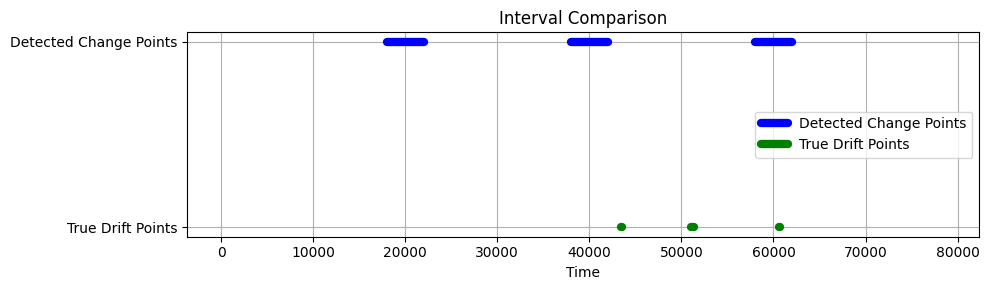

In [ ]:
from helper_lib import visualize_interval_differences

first_key = list(results.keys())[0]
results[first_key]['intervals_b']
visualize_interval_differences(results[first_key]['intervals_a'], results[first_key]['intervals_b'], labels=('Detected Change Points', 'True Drift Points'))

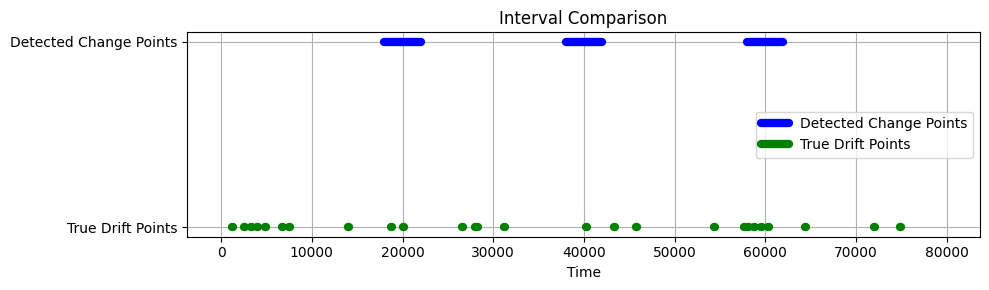

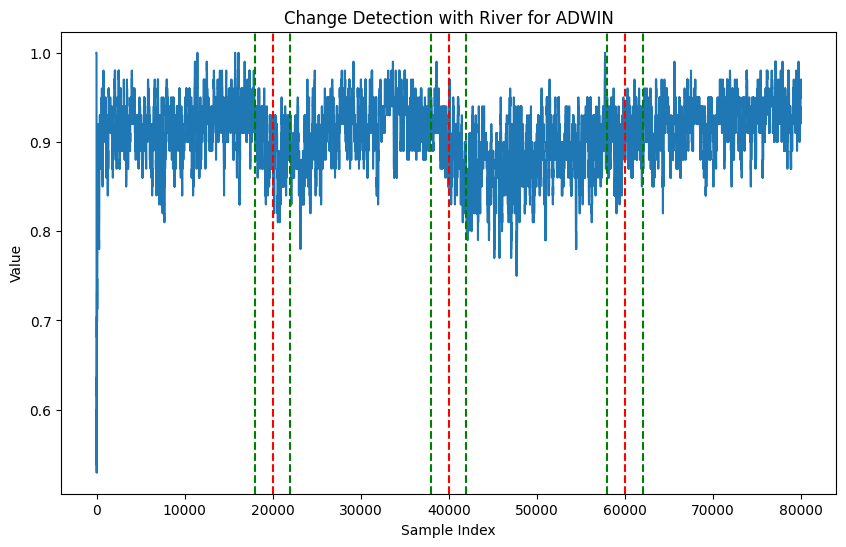

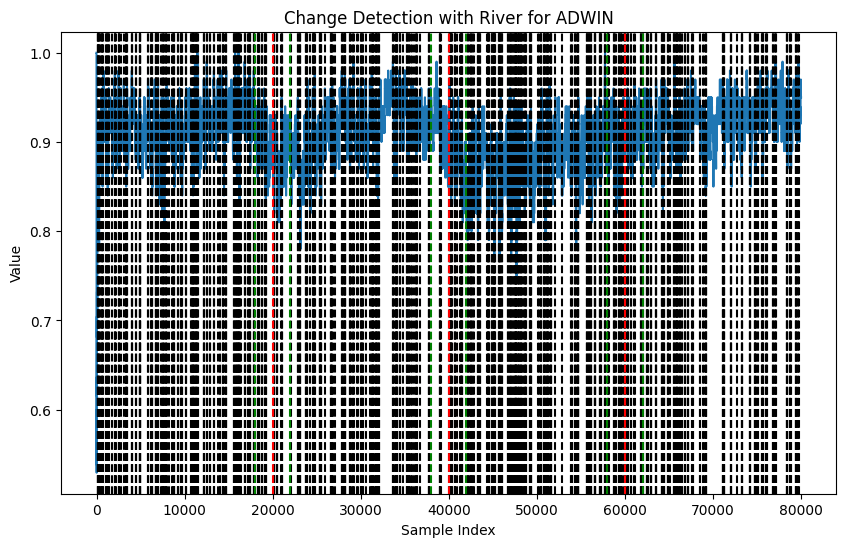

In [ ]:
from helper_lib import visualize_interval_differences

first_key = list(results.keys())[0]
results[first_key]['intervals_b']

intervals_b = transform_drift_detections_into_intervals(
        results[first_key]['detected_change_points']['ADWIN'],
        max_gap=50,
        min_group_size=1
    )
visualize_interval_differences(results[first_key]['intervals_a'], intervals_b, labels=('Detected Change Points', 'True Drift Points'))

from helper_lib import visualize_results

visualize_results({"ADWIN":[]}, results[first_key]['true_drift_points'],results[first_key]['drift_widths'], results[first_key]['accuracys'])

visualize_results(results[first_key]['detected_change_points'], results[first_key]['true_drift_points'],results[first_key]['drift_widths'], results[first_key]['accuracys'])